In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import torch
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

We are using device name "cuda"


In [28]:
# Model #

import torch
import torch.nn as nn

architecture_config = [
    # Tuple: (kernel_size, num_filters, stride, padding)
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    # List: tuples and then last integer rpresents number of repeats
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))   


class Yolov2(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov2, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

def test(S=7, B=2, C=20):
    model = Yolov2(split_size=S, num_boxes=B, num_classes=C)
    x = torch.randn((2, 3, 448, 448))
    print(model(x).shape)

test()

torch.Size([2, 1470])


In [29]:
# utils #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [30]:
# loss function #
# Follow the paper to to the loss function
class YoloLoss(nn.Module):
    # The original yolo has 7*7 cells, and 2 boundong boxes, with 20 classes
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.mse = nn.MSELoss(reduction="sum")
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # reshape the prediction to 7*7*30
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B*5)

        # the intersection over union for bouding box
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        #Concatnate iou b1 and iou b2
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)

        #   FOR BOX COORDINATES    #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        #   FOR OBJECT LOSS    #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        #   FOR NO OBJECT LOSS    #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        #   FOR CLASS LOSS   #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss


In [31]:
# dataset #
import os
import pandas as pd
from PIL import Image


class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [32]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""
# Train Cell

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 6 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 30
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "/content/drive/MyDrive/ECE570/YOLOv1/overfit.pth.tar"
IMG_DIR = "/content/drive/MyDrive/ECE570/YOLOv1/data/images"
LABEL_DIR = "/content/drive/MyDrive/ECE570/YOLOv1/data/labels"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = Yolov2(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "/content/drive/MyDrive/ECE570/YOLOv1/data/100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "/content/drive/MyDrive/ECE570/YOLOv1/data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        if mean_avg_prec > 0.7:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
            import time
            time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)


if __name__ == "__main__":
    main()

Train mAP: 0.0


100%|██████████| 18/18 [00:02<00:00,  6.59it/s, loss=34.2]

Mean loss was 288.44134351942273


Train mAP: 0.0


100%|██████████| 18/18 [00:02<00:00,  6.62it/s, loss=53.5]

Mean loss was 176.68576600816516


Train mAP: 0.0


100%|██████████| 18/18 [00:02<00:00,  6.62it/s, loss=8.14]

Mean loss was 138.9959077835083


Train mAP: 0.0


100%|██████████| 18/18 [00:02<00:00,  6.64it/s, loss=7.86]

Mean loss was 109.16736849149068


Train mAP: 0.0037916400469839573


100%|██████████| 18/18 [00:02<00:00,  6.47it/s, loss=13.6]

Mean loss was 93.35961225297716


Train mAP: 0.040331073105335236


100%|██████████| 18/18 [00:02<00:00,  6.66it/s, loss=4.49]

Mean loss was 78.1312010023329


Train mAP: 0.05903102084994316


100%|██████████| 18/18 [00:02<00:00,  6.57it/s, loss=6.72]

Mean loss was 68.39889833662245


Train mAP: 0.11443112790584564


100%|██████████| 18/18 [00:02<00:00,  6.61it/s, loss=12.6]

Mean loss was 62.08087248272366


Train mAP: 0.1080901175737381


100%|██████████| 18/18 [00:02<00:00,  6.66it/s, loss=10.6]

Mean loss was 55.839485751258


Train mAP: 0.1809544861316681


100%|██████████| 18/18 [00:02<00:00,  6.58it/s, loss=6.71]

Mean loss was 49.023101806640625


Train mAP: 0.16420817375183105


100%|██████████| 18/18 [00:02<00:00,  6.25it/s, loss=5.25]

Mean loss was 45.70524112383524


Train mAP: 0.26700228452682495


100%|██████████| 18/18 [00:02<00:00,  6.57it/s, loss=8.58]

Mean loss was 42.435066064198814


Train mAP: 0.4226820468902588


100%|██████████| 18/18 [00:02<00:00,  6.64it/s, loss=4.93]

Mean loss was 39.88078573015001


Train mAP: 0.4350883364677429


100%|██████████| 18/18 [00:02<00:00,  6.56it/s, loss=7.85]

Mean loss was 37.623904599083794


Train mAP: 0.4678162932395935


100%|██████████| 18/18 [00:02<00:00,  6.65it/s, loss=9.17]

Mean loss was 38.94117154015435


Train mAP: 0.5154223442077637


100%|██████████| 18/18 [00:02<00:00,  6.63it/s, loss=24.1]

Mean loss was 36.58182621002197


Train mAP: 0.5680922865867615


100%|██████████| 18/18 [00:02<00:00,  6.64it/s, loss=3.54]

Mean loss was 35.928355322943794


Train mAP: 0.4378567636013031


100%|██████████| 18/18 [00:02<00:00,  6.61it/s, loss=8.69]

Mean loss was 35.07791572146945


Train mAP: 0.5694721937179565


100%|██████████| 18/18 [00:02<00:00,  6.53it/s, loss=13]

Mean loss was 37.30123991436429


Train mAP: 0.631722629070282


100%|██████████| 18/18 [00:02<00:00,  6.55it/s, loss=7.05]

Mean loss was 34.33533149295383


Train mAP: 0.5617064237594604


100%|██████████| 18/18 [00:02<00:00,  6.67it/s, loss=12.3]

Mean loss was 31.857425053914387


Train mAP: 0.6251291632652283


100%|██████████| 18/18 [00:02<00:00,  6.63it/s, loss=5.12]

Mean loss was 33.20585687955221


Train mAP: 0.5688166618347168


100%|██████████| 18/18 [00:02<00:00,  6.62it/s, loss=6.01]

Mean loss was 28.913056082195705


Train mAP: 0.6710304021835327


100%|██████████| 18/18 [00:02<00:00,  6.66it/s, loss=23.1]

Mean loss was 29.60535462697347


Train mAP: 0.6822792291641235


100%|██████████| 18/18 [00:02<00:00,  6.68it/s, loss=3.58]

Mean loss was 32.36994882424673


Train mAP: 0.68517005443573


100%|██████████| 18/18 [00:02<00:00,  6.67it/s, loss=2.74]

Mean loss was 27.776817268795437


Train mAP: 0.7222703695297241
=> Saving checkpoint


100%|██████████| 18/18 [00:02<00:00,  6.23it/s, loss=8.88]

Mean loss was 27.320177290174698


Train mAP: 0.7156150937080383
=> Saving checkpoint


100%|██████████| 18/18 [00:02<00:00,  6.30it/s, loss=4.76]

Mean loss was 24.024474223454792


Train mAP: 0.7878860831260681
=> Saving checkpoint


100%|██████████| 18/18 [00:02<00:00,  6.06it/s, loss=3.19]

Mean loss was 23.244170784950256


Train mAP: 0.7479745745658875
=> Saving checkpoint


100%|██████████| 18/18 [00:02<00:00,  6.16it/s, loss=4.67]

Mean loss was 22.259845813115437


=> Loading checkpoint
Mean loss was 38.542038917541504
Test mAP: 0.2281743884086609


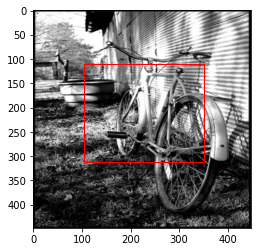

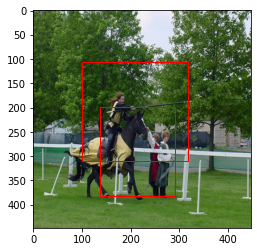

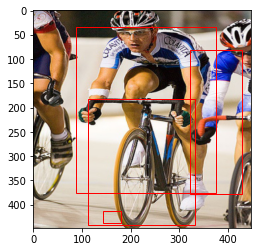

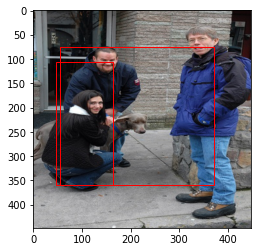

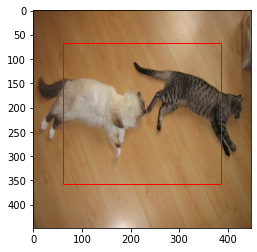

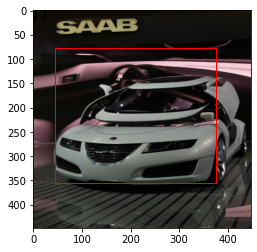

Test mAP: 0.2281743884086609


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [33]:
# test cell
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def test_fn(test_loader, model, optimizer, loss_fn):
    mean_loss = []

    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

def main():
    model = Yolov2(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "/content/drive/MyDrive/ECE570/YOLOv1/data/100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "/content/drive/MyDrive/ECE570/YOLOv1/data/8examples.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):
        test_fn(test_loader, model, optimizer, loss_fn)
        pred_boxes, target_boxes = get_bboxes(
            test_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Test mAP: {mean_avg_prec}")
        for x, y in test_loader:
            x = x.to(DEVICE)
            for idx in range(6):
                bboxes = cellboxes_to_boxes(model(x))
                bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
                plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
            print(f"Test mAP: {mean_avg_prec}")

            import sys
            sys.exit()
        

if __name__ == "__main__":
    main()